In [20]:
import h5py
import numpy as np
import os,sys
import glob
from scipy import stats
import random
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../models/20210219_MC_ensemble/')

# Rejection algorithm based on random walk
We created a tiny ensemble of 100 different SHEMAT-Suite and will use a rejection algorithm based on the Metropolis acceptance probability to get a posterior ensemble of models.  
The Metropolis acceptance probability is defined as:  

$$ \alpha(x_{t-1},z) = \begin{cases} min\big(\frac{p(z)}{p(x_{t-1})},1\big), & \text{if } p(x_{t-1}) > 0\\
1, & \text{if } p(x_{t-1}) = 0 \end{cases} $$  

A different approach would be to assess the missfit (as RMS error) of each realisation.  

$$ \alpha(x_{t-1},z) = \begin{cases} exp\big(-\frac{S(z) - S(x_{t-1}) }{u_T}\big), & \text{if } S(z) > S(x_{t-1})\\
1, & \text{otherwise }  \end{cases} $$  

We will use the second approach for now...also because we wrote it in the abstract.  
As discretization error, we take a value from Elison(2015), $u_{T-discr} = 0.7$ K  

Using Gauss error propagation, we assess a potential error for the realisations.  

$$ u_T = \sqrt{\big(\frac{\partial T}{\partial x_1}u_1 \big)^2 + ... + \big(\frac{\partial T}{\partial x_n}u_n \big)^2} $$

Literature sources for log-errors:
_The lower part of the disturbed log profile (below the cross-over point) was rotated to match these corrected tempera-tures. In the upper part of the profile, the same correction as for method A was applied. The quality of this correction method strongly depends on the correct calculation of the lowermost profile temperatures. According to Förster (2001), most of the corrected tem-peratures have errors of ± 3 to 5 K._ https://doi.org/10.1186/s40517-020-00181-w  


 _The effective accuracy of commercial temperature logs is ±0.5ºC (Blackwell and Spafford, 1987)._  http://www.sprensky.com/publishd/temper2.html  
 
 _More normal accuracies are +- 0.25 °C over 0-200 °C_ Keith Geothermal Energy lecture  
 
 For errors as a function of e.g. logging speed, measurement response time etc, look https://doi.org/10.1016/j.petrol.2020.107727

In [40]:
f = h5py.File('../models/20210219_MC_ensemble/PCT_base_model_final.h5','r')

In [43]:
z,y,x = f['uindex'].shape

In [48]:
101/2

50.5

In [49]:
def fahrenheit_to_celsius(temp_fahrenheit, difference=False):
    if not difference:
        return (temp_fahrenheit - 32) * 5 / 9
    else:
        return temp_fahrenheit * 5 / 9
    
    
def extTui(datafile, dimension=3, direction='x'):
    f = h5py.File(datafile,'r')
    z, y, x = f['temp'].shape
    if dimension==3:
        temp = f['temp'][:,:,:]
        uindex = f['uindex'][:,:,:]
    elif dimension==2:
        if direction=='x':
            temp = f['temp'][:,:,x//2]
            uindex = f['uindex'][:,:,x//2]
        elif direction=='y':
            temp = f['temp'][:,y//2,:]
            uindex = f['uindex'][:,y//2,:]
        elif direction=='z':
            temp = f['temp'][z//2,:,:]
            uindex = f['uindex'][z//2,:,:]
    return temp,uindex
    

In [3]:
# define uT
T_error = 0.25 # temperature error tool accuracy
s_error = fahrenheit_to_celsius(1.25, difference=True) # sensor response time of 2 sec and 1 year after drilling
l_error = fahrenheit_to_celsius(1.25, difference=True) # logging speed of 20/ft after 1 year
d_error = 1.0 # estimated temperature error by discretization
#u_T = np.sqrt(T_error[0]**2 + T_error[1]**2 + T_error[2]**2 + T_error[3]**2 + d_error**2)
#u_T = np.sum(T_error**2)/4
u_T = np.sqrt(T_error**2 + s_error**2 + l_error**2 + d_error**2)
print(u_T)

1.4237296698599444


In [4]:
# load Simulation outputs. Those outputs get written by SHEMAT-Suite if runmode = 1
outp_path = '../models/20210219_MC_ensemble/'
diffs = np.loadtxt(outp_path+'PCT_MC_0var_TCt_final.dat',skiprows=3,usecols=(8,),dtype=float)
for i in range(1,100):
    n = np.loadtxt(outp_path+f'PCT_MC_{i}var_TCt_final.dat',skiprows=3,usecols=(8,),dtype=float)
    diffs=np.vstack([diffs,n])

In [5]:
# calculate RMSE of each realisation.
n = diffs.shape[1] # as we have 4 data points for temperature

diffs_sq = diffs**2
ssr = diffs_sq.sum(axis=1)
rmse = np.sqrt((diffs_sq.sum(axis=1)/n))

In [6]:
# this is a matrix with all vectors. First 96 columns are differences of the wells, then the column is the SSR, 
# final column is RMSE
tot_diffs = np.column_stack((diffs,ssr,rmse))
print(tot_diffs.shape)
# add index to the realizations
ind = np.array(range(100))
tot_diffs = np.column_stack((tot_diffs,ind))

(100, 98)


In [7]:
diffs[0,:] - diffs[72,:]

array([-1.5201195, -1.461665 , -1.403697 , -1.3462403, -1.2893066,
       -1.2328994, -1.177    , -1.1215621, -1.0665283, -1.0118893,
       -0.957759 , -0.9043045, -0.8516312, -0.799683 , -0.7481756,
       -0.6966115, -0.6445547, -0.5926642, -0.5419091, -0.4931279,
       -0.4469584, -0.4038413, -0.3639712, -0.3270807, -0.2918596,
       -0.2546062, -0.2212619, -0.1942998, -0.1707273, -0.1490087,
       -0.1283688, -0.1085283, -0.0957589, -0.0855443, -0.0741754,
       -0.0614251, -0.0469003, -0.03273  , -0.0189854, -1.1048345,
       -1.0635816, -1.0211166, -0.977543 , -0.9329919, -0.8876188,
       -0.8415941, -0.7950881, -0.7482432, -0.7011275, -0.6536518,
       -0.5966005, -0.5482866, -0.5098773, -0.4639739, -0.4102419,
       -0.3501038, -0.2919517, -0.2353215, -0.1797906, -0.1273862,
       -0.077933 , -3.460852 , -3.133596 , -2.793566 , -2.453768 ,
       -2.070575 , -1.814628 , -1.662045 , -1.458957 , -1.241025 ,
       -1.042408 , -0.86238  , -0.691421 , -0.527159 , -0.3681

## Rejection sampling
we now start with a random sample and go randomly through the pool, accepting and rejecting realizations.
The algorithm starts with one refrence sample `Ref`. Then, iteratively, samples (= realizations) get accepted, rejected based on their RMSE values. That is why we use the 6th column of `tot_diffs`. Alternatively, one could also just use the `rmse` array.

In [78]:
# Chronological implemntation - start von 1 bis N 
# Can be used here, if samples generated are already in a random order and not correlated.
# That is usually the case with GemPy exports to SHEMAT-Suite.
col = 97
Ref = tot_diffs[0,col]
accept = []
P = []
k=0
for i in range(1,100):
    if tot_diffs[i,col] < Ref:
        Ref = tot_diffs[i,col]
        accept.append(i)
        
    elif random.random() < np.exp(-(tot_diffs[i,col] - Ref)/(u_T)):
        P.append(np.exp(-(tot_diffs[i,col] - Ref)/(u_T)))
        Ref = tot_diffs[i,col]
        accept.append(i)
        k += 1
print(len(accept))
print(accept)

23
[1, 4, 8, 12, 13, 14, 19, 23, 24, 29, 30, 44, 50, 64, 71, 76, 84, 85, 88, 93, 96, 97, 99]


And we see, temperature data is not sensitive to changes in the PCT-depth.  

But what if we also treat the thermal conductivity as an uncertain parameter?

*Then the rejection is way more rigorous.*

In [79]:
fids = glob.glob('/home/bl2/ownCloud/SHEMAT_GeoMol/20210219_MC_outputs/*.h5')

In [80]:
outpath = '/home/bl2/ownCloud/SHEMAT_GeoMol/20210219_MC_outputs/'
poTemp = []
poUi = []
dicfil = {}
for fn in fids:
    for i in accept:
        if fn == outpath+"PCT_MC_{}var_TCt_final.h5".format(i):
            dT,dui = extTui(fn, dimension=2, direction='y')
            poTemp.append(dT)
            poUi.append(dui)            
            dicfil[fn.split('/')[-1]] = dui
            

In [81]:
poTempa = np.asarray(poTemp)
poUia = np.asarray(poUi)
accepta = np.asarray(accept)
print(poUia.shape,poTempa.shape,accepta.shape)
np.savetxt('accepted_realisations',accepta,fmt='%i',delimiter=' ',newline='\n')
#np.savetxt('posterior_Temps',poTempa,fmt='%.5f',delimiter=' ',newline='\n',header=" posterior 61 realizations for Temperature")
#np.savetxt('posterior_Uindex',poUia,fmt='%i',delimiter=' ',newline='\n')

(23, 60, 100) (23, 60, 100) (23,)


In [82]:
# calculate mean temperature field and mean posterior uindex
mTemp = np.mean(poTempa,axis=0)
mUi = np.mean(poUia,axis=0)
# import y and z for visualising
plfn = h5py.File('../models/20210219_MC_ensemble/PCT_base_model_final.h5','r')
x = plfn['x'][0,0,:]
y = plfn['y'][0,:,0]
z = plfn['z'][:,0,0]
refT = plfn['temp'][:,25,:]

In [83]:
poUi[0].shape

(60, 100)

Text(0, 0.5, 'depth[m]')

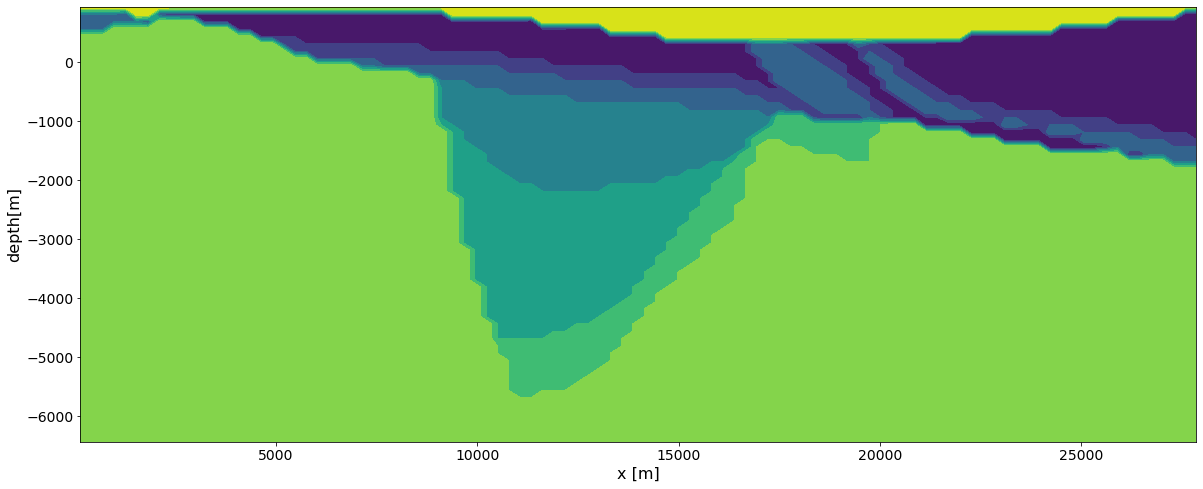

In [84]:
fig = plt.figure(figsize=(20,8))
cs = plt.contourf(x,z-6500.,mUi,cmap='viridis')
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth[m]',fontsize=16)

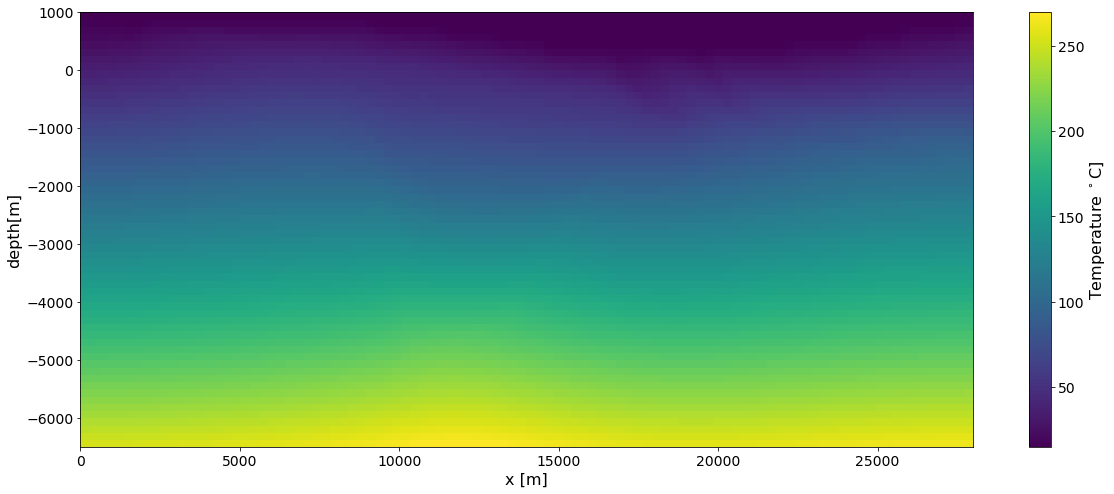

In [85]:
fig = plt.figure(figsize=(20,8))
cs = plt.pcolor(x,z-6500.,mTemp,cmap='viridis', shading='auto')
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth[m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='vertical')
cbar.set_label('Temperature $^\circ$C]',fontsize=16)
cbar.ax.tick_params(labelsize=14)

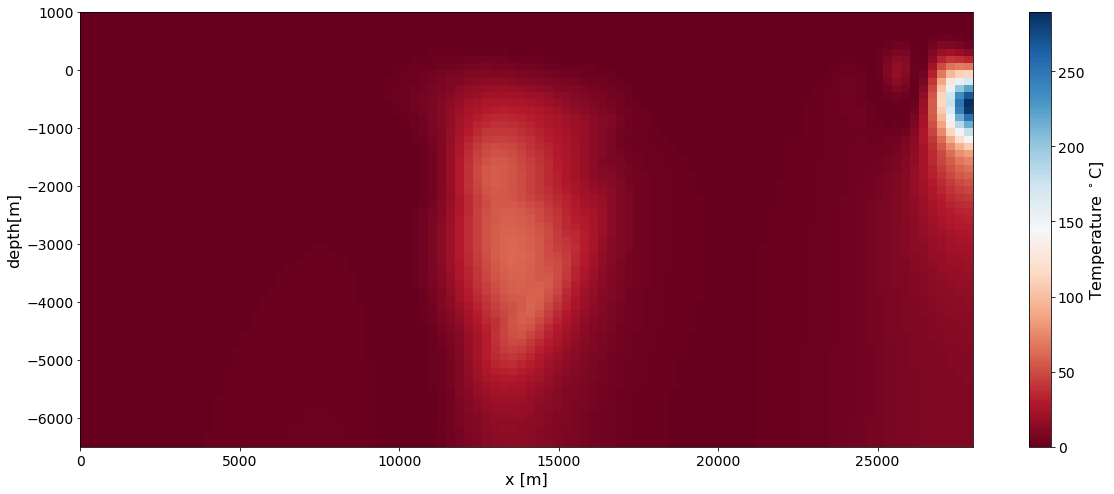

In [87]:
#plot ssr of mean posterior and reference model
fig = plt.figure(figsize=(20,8))
cs = plt.pcolor(x,z-6500.,(refT-mTemp)**2,cmap='RdBu', shading='auto')
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth[m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='vertical')
cbar.set_label('Temperature $^\circ$C]',fontsize=16)
cbar.ax.tick_params(labelsize=14)